<a href="https://colab.research.google.com/github/mellalbuquerque/fashiondata/blob/main/Spring_2025_Ready_To_Wear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
import unicodedata
import pandas as pd

# Carregar modelo spaCy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Retrieving data

In [ ]:
# URL atualizada para Spring 2025 Ready-to-Wear
url = 'https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear'

# Raspagem de links das páginas de shows
response_show = requests.get(url)
list_fashion_shows = []
if response_show.status_code == 200:
    soup_show = BeautifulSoup(response_show.text, 'html.parser')
    elements = soup_show.find_all('a', class_='NavigationInternalLink-cWEaeo')

    for element in elements:
        if 'fashion-shows' in element['href']:
            list_fashion_shows.append(element['href'])

articles = []

# Percorrendo cada link e armazenando o conteúdo
for url_fashion_show in list_fashion_shows:
    full_url = 'https://www.vogue.com' + url_fashion_show
    response_show = requests.get(full_url)

    if response_show.status_code == 200:
        soup_show = BeautifulSoup(response_show.text, 'html.parser')
        show_text_element = soup_show.find('div', class_='body__inner-container')

        try:
            articles.append(show_text_element.text)
            print(f'Sucesso: {full_url}')
        except:
            print(f'Erro: {full_url}')



Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/apotts
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/a-l-c
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/a-w-a-k-e
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/aaron-esh
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/abra
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/acne-studios
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/adam-lippes
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/adeam
Erro: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/agl
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/ahluwalia-studio
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/akris
Sucesso: https://www.vogue.com/fashion-shows/spring-2025-ready-to-wear/azzedine-alaia
Sucesso: https://www.vogue.com/fashion-s

In [ ]:
print(articles)

['Aaron Potts returned to the New York Men’s Day showcase this morning after a season away. “Men’s Day to me is like a family reunion,” he said. “We all come here to get together and do our thing, and we know what we’re doing.”Potts had two ideas in mind for spring: The color blue—its textures, shades, and a variety of iterations from patchwork and denim to fringe—and the goal of keeping his clothes exciting but not too precious. “It’s about making and finding that special element in an everyday thing,” he said.Taking a hue as versatile as blue was an effective starting point for Potts, and his ingenuity in approaching its many applications lent his collection a good dose of dimension, particularly after his blackout fall lineup. In his silhouettes, Potts continued to expand on his exploration of utility in the context of everyday city sophistication, finding more success in his oversized shirting and his riffs on quintessential workwear styles. A pair of coveralls, which he shaped loo

Pré-processamento de texto

In [ ]:
# Função de limpeza de texto
def clean_text(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Tokenização e lematização
def lemmatize_article(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Combinar lemmas em strings para n-gramas
def combine_lemmas(preprocessed_articles):
    return [" ".join(article) for article in preprocessed_articles]

# Pipeline completo para processamento de artigos
def preprocess_articles(articles):
    cleaned_articles = [clean_text(article) for article in articles]
    lemmatized_articles = [lemmatize_article(article) for article in cleaned_articles]
    combined_articles = combine_lemmas(lemmatized_articles)
    return combined_articles

preprocessed_articles = preprocess_articles(articles)


In [ ]:
print(preprocessed_articles)

['aaron pott return new york mens day showcase morning season away men day like family reunion say come thing know doingpotts idea mind spring color blueit texture shade variety iteration patchwork denim fringeand goal keep clothe exciting precious make find special element everyday thing saidtake hue versatile blue effective starting point pott ingenuity approach application lend collection good dose dimension particularly blackout fall lineup silhouette pott continue expand exploration utility context everyday city sophistication find success oversized shirting riff quintessential workwear style pair coverall shape loosely ease particular hitentirely new chez pott run jersey style designer explain find sculptural silhouette construct close body simply oversized signature jersey right material flexibility promise new ground pott particularly womenswear space apotts label commit genderless outlookand outputthe retail landscape considerably flexible pott good sport way s include women o

N-gramas gerais

Top 20 Bigrams: [('new york', 91), ('spring collection', 78), ('feel like', 76), ('look like', 56), ('fashion week', 50), ('designer say', 32), ('starting point', 28), ('year ago', 28), ('color palette', 26), ('trench coat', 23), ('black white', 22), ('opening look', 22), ('slip dress', 21), ('york fashion', 21), ('knit dress', 19), ('little bit', 19), ('say want', 19), ('creative director', 17), ('look book', 15), ('say designer', 15)]
Top 30 Trigrams: [('new york fashion', 21), ('york fashion week', 19), ('london fashion week', 9), ('central saint martin', 8), ('cfdavogue fashion fund', 7), ('collection feel like', 7), ('de saint sernin', 7), ('new york city', 7), ('palais de tokyo', 6), ('paris fashion week', 6), ('yve saint laurent', 6), ('spring collection designer', 5), ('biascut slip dress', 4), ('present spring collection', 4), ('starting point collection', 4), ('want feel like', 4), ('woman want wear', 4), ('day new york', 3), ('design spring collection', 3), ('designer explai

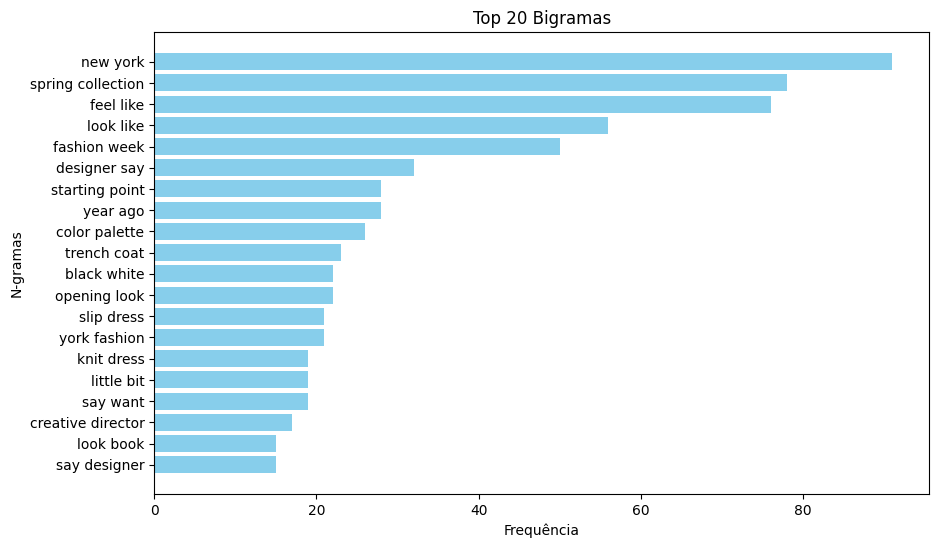

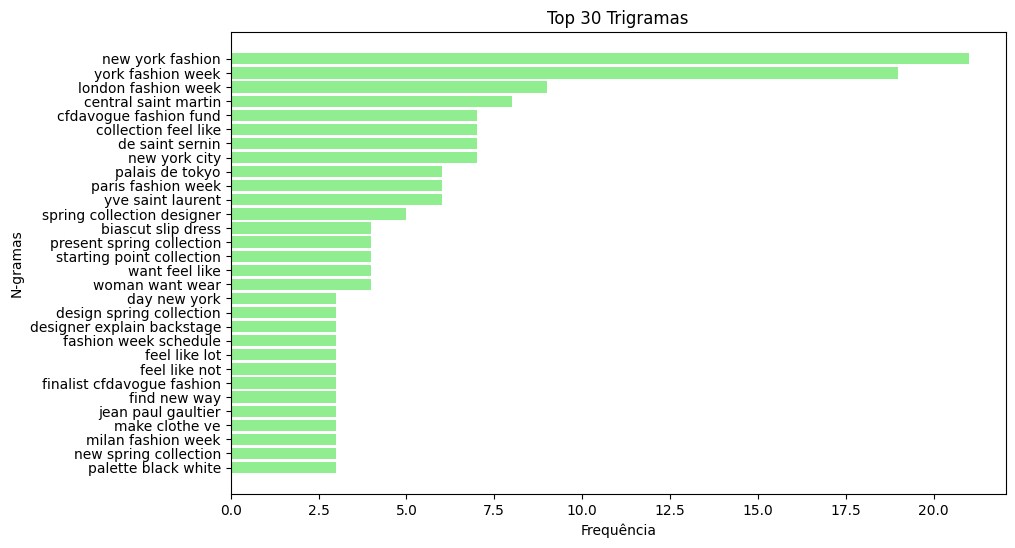

In [ ]:
# Função para extrair os n-gramas mais frequentes
def get_top_ngrams(corpus, n, top_k):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))
    return ngram_counts.most_common(top_k)

# Função para plotar gráficos de n-gramas
def plot_ngrams(ngrams, title, color="blue"):
    labels, values = zip(*ngrams)
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values, color=color)
    plt.xlabel("Frequência")
    plt.ylabel("N-gramas")
    plt.title(title)
    plt.gca().invert_yaxis()  # Maior valor no topo
    plt.show()


# Pipeline completo
# 1. Limpeza
cleaned_articles = [clean_text(article) for article in articles]

# 2. Lematização
lemmatized_articles = [lemmatize_article(article) for article in cleaned_articles]

# 3. Combinar os lemmas para n-gramas
combined_articles = combine_lemmas(lemmatized_articles)

# 4. Obter os bigramas e trigramas mais frequentes
top_20_bigrams = get_top_ngrams(combined_articles, 2, 20)
top_30_trigrams = get_top_ngrams(combined_articles, 3, 30)

# 5. Exibir os resultados
print("Top 20 Bigrams:", top_20_bigrams)
print("Top 30 Trigrams:", top_30_trigrams)

# 6. Gerar gráficos
plot_ngrams(top_20_bigrams, "Top 20 Bigramas", color="skyblue")
plot_ngrams(top_30_trigrams, "Top 30 Trigramas", color="lightgreen")

Relacionados a moda

In [ ]:
# Lista de palavras relacionadas à moda
fashion_words = [
    "cashmere", "shearling", "gingham", "plaid", "minis", "leather", "outerwear", "draping",
    "blouse", "jacket", "pumps", "dress", "pastel", "silhouette", "proportions", "accessories",
    "bracelet", "jewelry", "belt", "cotton", "voile", "skirt", "mini", "sequins", "fabric",
    "satin", "turtleneck", "fringe", "organic", "poplin", "crop", "blazer", "pencil", "midi",
    "cardigans", "pleated", "jacquard", "seersucker", "stripes", "sustainable", "denim", "silk",
    "neon", "lace", "trench", "floral", "minimalist", "knitwear", "velvet", "tweed", "chiffon",
    "linen", "wool", "polyester", "embroidery", "crochet", "ruffle", "sheer", "transparent",
    "layered", "peplum", "cape", "bodysuit", "jumpsuit", "cardigan", "coat", "anorak", "parka",
    "hoodie", "sweater", "pullover", "tank", "top", "shirt", "t-shirt", "jeans", "trousers",
    "pants", "shorts", "culottes", "overalls", "romper", "kimono", "suit", "gown", "evening",
    "cocktail", "bridal", "maxi", "wrap", "sequin", "metallic", "crystal", "glitter", "sparkle",
    "gold", "silver", "bronze", "black", "white", "red", "blue", "green", "yellow", "orange",
    "purple", "pink", "brown", "beige", "nude", "ivory", "grey", "navy", "turquoise", "teal",
    "coral", "fuchsia", "burgundy", "emerald", "mustard", "peach", "aqua", "lime", "lavender",
    "charcoal", "magenta", "indigo", "amber", "scarlet", "ochre", "khaki", "taupe", "mauve",
    "paisley", "flannel", "herringbone", "houndstooth", "argyle", "geometric", "polka", "dots",
    "stripe", "checks", "abstract", "graphic", "artsy", "vintage", "retro", "modern", "edgy",
    "classic", "boho", "grunge", "punk", "gothic", "preppy", "minimal", "maximal", "eclectic",
    "athleisure", "streetwear", "casual", "formal", "business", "smart", "loungewear", "resort",
    "beachwear", "activewear", "intimates", "lingerie", "corset", "bustier", "bralette",
    "shapewear", "nightwear", "robes", "slippers", "scarves", "gloves", "hats", "caps",
    "beanies", "berets", "fedoras", "sunglasses", "belts", "handbags", "totes", "clutches",
    "crossbody", "backpacks", "satchels", "duffle", "briefcase", "sling", "mules", "sandals",
    "boots", "sneakers", "loafers", "oxfords", "brogues", "heels", "wedges", "espadrilles",
    "flats", "platforms", "lace-up", "zip-up", "button-down", "embroidered", "patchwork",
    "distressed", "washed", "stonewashed", "raw", "ripped", "frayed", "cropped", "oversized",
    "slim-fit", "regular-fit", "tailored", "double-breasted", "single-breasted", "tapered",
    "straight-leg", "bootcut", "flare", "wide-leg", "baggy", "high-waist", "mid-rise", "low-rise",
    "asymmetric", "off-shoulder", "halter", "strapless", "one-shoulder", "spaghetti-strap",
    "long-sleeve", "short-sleeve", "sleeveless", "cap-sleeve", "bell-sleeve", "puff-sleeve",
    "raglan", "quilted", "padded", "fur-lined", "leather-trim", "denim-trim", "patch-pocket",
    "welt-pocket", "flap-pocket", "side-pocket", "zippered-pocket", "cargo-pocket", "bucket",
    "bomber", "aviator", "trench-coat", "peacoat", "car-coat", "duster", "puffer", "raincoat",
    "windbreaker", "vest", "gilet", "bodycon", "a-line", "fit-and-flare", "ballgown",
    "empire-waist", "drop-waist", "sheath", "shift", "tent", "tiered", "flounced"
]
fashion_set = set(fashion_words)

# Carregar modelo spaCy
nlp = spacy.load("en_core_web_sm")

# Função para limpar e remover stopwords
def clean_text_remove_stopwords(text):
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove pontuação
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop and not token.is_punct])

# Limpar e combinar artigos
cleaned_corpus = [clean_text_remove_stopwords(article) for article in articles]

# Função para gerar n-gramas e filtrar por palavras de moda
def generate_fashion_ngrams(corpus, n, fashion_set, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))

    # Filtrar os n-gramas que contêm pelo menos uma palavra de moda
    filtered_ngrams = {
        ngram: count
        for ngram, count in ngram_counts.items()
        if any(word in fashion_set for word in ngram.split())
    }

    # Ordenar e retornar os top-k
    return Counter(filtered_ngrams).most_common(top_k)

# Gerar bigramas e trigramas relacionados à moda
fashion_bigrams = generate_fashion_ngrams(cleaned_corpus, 2, fashion_set, top_k=20)
fashion_trigrams = generate_fashion_ngrams(cleaned_corpus, 3, fashion_set, top_k=30)

# Criar DataFrames para visualização
df_bigrams = pd.DataFrame(fashion_bigrams, columns=["Bigram", "Frequency"])
df_trigrams = pd.DataFrame(fashion_trigrams, columns=["Trigram", "Frequency"])

# Exibir os resultados
print("\nTop 20 Bigrams Relacionados à Moda:")
print(df_bigrams)

print("\nTop 30 Trigrams Relacionados à Moda:")
print(df_trigrams)



Top 20 Bigrams Relacionados à Moda:
            Bigram  Frequency
0      black white         22
1      trench coat         13
2       black lace         10
3     trench coats         10
4    black leather          9
5       knit dress          9
6       pair jeans          9
7     white cotton          9
8      black dress          8
9    evening looks          8
10     jacket worn          8
11    mini dresses          8
12      polka dots          8
13      red carpet          8
14      slip dress          8
15      white lace          8
16   floral prints          7
17      white blue          7
18       baby blue          6
19  bermuda shorts          6

Top 30 Trigrams Relacionados à Moda:
                    Trigram  Frequency
0       palette black white          3
1            red white blue          3
2         25 years business          2
3   adorned delicate floral          2
4        black column dress          2
5       black white instead          2
6          blazer capr

Nuvem de palavras

In [ ]:
# Categorias de moda
fashion_categories = {
    "Fabrics": [
        "cashmere", "shearling", "denim", "silk", "lace", "velvet", "tweed", "chiffon", "linen",
        "wool", "polyester", "satin", "jacquard", "crochet", "embroidery", "sequin", "metallic",
        "crystal", "glitter", "leather", "poplin", "voile", "stonewashed", "washed",
        "distressed", "denim-trim", "fur-lined"
    ],
    "Clothing": [
        "blouse", "jacket", "pumps", "dress", "skirt", "midi dress", "mini", "culottes", "romper",
        "kimono", "suit", "gown", "coat", "anorak", "parka", "hoodie", "sweater", "pullover",
        "cardigan", "pants", "jeans", "shorts", "top", "shirt", "t-shirt", "jumpsuit", "corset",
        "bodysuit", "bralette", "bustier", "wrap", "trench", "trench-coat", "vest", "bomber",
        "car-coat", "peacoat", "duster", "puffer", "raincoat", "windbreaker", "leggings",
        "activewear", "beachwear", "bridal", "cocktail", "evening", "maxi", "wrap", "shift",
        "tent", "bodycon", "a-line", "fit-and-flare", "ballgown", "empire-waist", "drop-waist",
        "peplum", "tiered", "flounced"
    ],
    "Colors": [
        "pastel", "gold", "silver", "bronze", "black", "white", "red", "blue", "green", "yellow",
        "orange", "purple", "pink", "brown", "beige", "nude", "ivory", "grey", "navy", "turquoise",
        "teal", "coral", "fuchsia", "burgundy", "emerald", "mustard", "peach", "aqua", "lime",
        "lavender", "charcoal", "magenta", "indigo", "amber", "scarlet", "ochre", "khaki", "taupe",
        "mauve"
    ],
    "Styles": [
        "minimalist", "maximal", "boho", "grunge", "punk", "gothic", "preppy", "eclectic",
        "athleisure", "streetwear", "casual", "formal", "business", "smart", "retro", "vintage",
        "modern", "classic", "edgy", "abstract", "graphic", "artsy", "geometric", "houndstooth",
        "argyle", "paisley", "polka", "dots", "checks", "striped", "herringbone", "gingham",
        "flannel", "layered", "tailored", "oversized", "cropped", "slim-fit", "regular-fit",
        "double-breasted", "single-breasted", "tapered", "straight-leg", "bootcut", "flare",
        "wide-leg", "baggy", "high-waist", "mid-rise", "low-rise", "asymmetric", "off-shoulder",
        "halter", "strapless", "one-shoulder", "spaghetti-strap", "long-sleeve", "short-sleeve",
        "sleeveless", "cap-sleeve", "bell-sleeve", "puff-sleeve", "raglan"
    ]
}

In [ ]:
# Unindo o texto do corpus
texto = " ".join(preprocessed_articles)

# Limpando o texto (opcional: remover pontuações e converter para minúsculas)
texto = re.sub(r"[^\w\s]", "", texto.lower())

# Criando uma lista de todas as palavras nas categorias
fashion_terms = [term.lower() for category in fashion_categories.values() for term in category]

# Dividindo o texto em palavras
palavras = texto.split()

# Contando a ocorrência de cada palavra nas categorias
contagem = Counter(palavra for palavra in palavras if palavra in fashion_terms)

# Exibindo os resultados
for termo, freq in contagem.items():
    print(f"{termo}: {freq}")


denim: 139
blue: 79
oversized: 41
suit: 96
coat: 104
brown: 21
green: 57
dress: 616
maxi: 11
flare: 10
skirt: 219
white: 188
lace: 93
leather: 132
jacket: 217
gown: 76
black: 200
jumpsuit: 12
beige: 13
shirt: 109
top: 79
red: 72
velvet: 12
silk: 103
vintage: 38
satin: 46
business: 54
pink: 67
wrap: 38
layered: 5
evening: 74
formal: 14
gold: 36
stonewashed: 1
yellow: 48
strapless: 21
embroidery: 43
navy: 16
gothic: 3
pastel: 19
peach: 5
asymmetric: 14
ochre: 5
shearling: 4
ivory: 9
mini: 31
puffer: 3
shift: 27
boho: 10
chiffon: 43
orange: 17
halter: 13
sequin: 45
crystal: 38
crochet: 43
modern: 33
corset: 31
graphic: 19
cocktail: 16
cropped: 17
silver: 37
blouse: 21
trench: 47
striped: 19
tiered: 7
sweater: 44
preppy: 6
cardigan: 29
vest: 31
baggy: 4
nude: 6
bomber: 21
bodysuit: 20
bustier: 2
classic: 60
wool: 26
punk: 14
mauve: 4
distressed: 5
jacquard: 28
voile: 3
smart: 12
romper: 3
houndstooth: 2
coral: 4
tweed: 19
khaki: 28
purple: 11
eclectic: 4
sleeveless: 23
peplum: 13
casual: 2

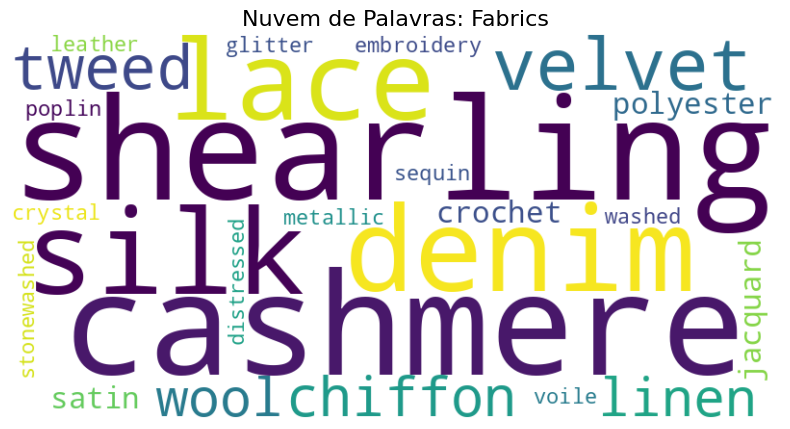

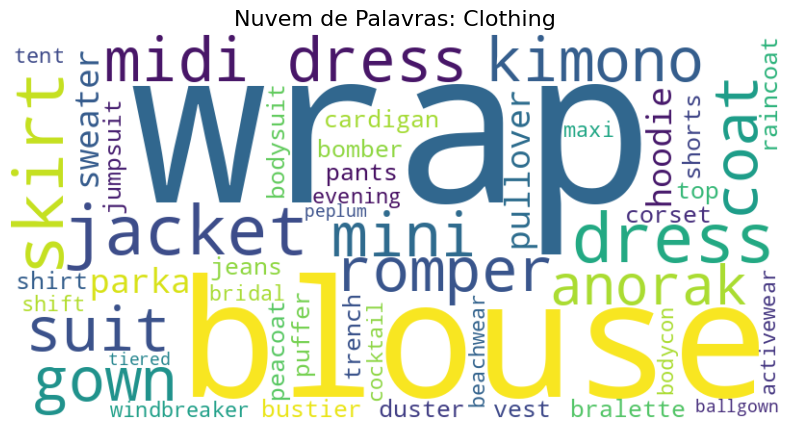

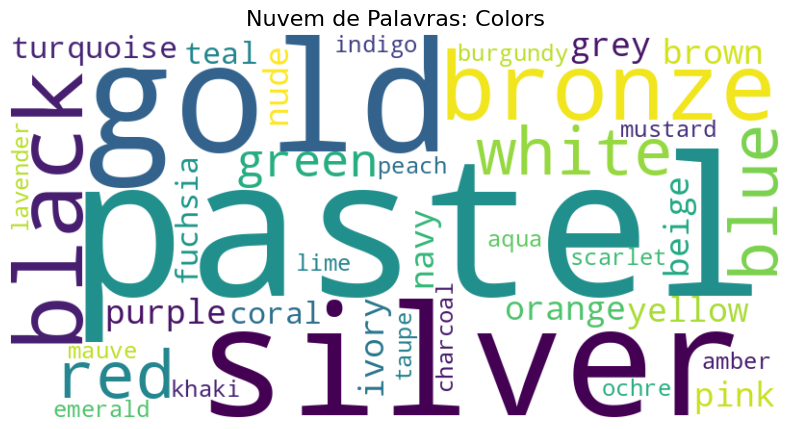

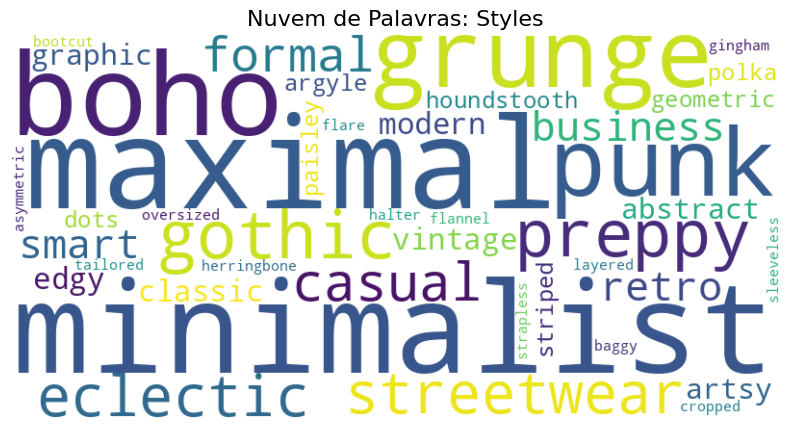

In [ ]:
# Função para criar nuvem de palavras
def criar_nuvem(categoria, palavras):
    # Filtrar palavras específicas da categoria no texto
    palavras_categoria = [palavra for palavra in palavras if palavra in texto]
    contagem = Counter(palavras_categoria)

    # Criar a nuvem de palavras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate_from_frequencies(contagem)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.title(f"Nuvem de Palavras: {categoria}", fontsize=16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Gerar nuvem de palavras para cada categoria
for categoria, palavras in fashion_categories.items():
    criar_nuvem(categoria, palavras)